In [2]:
#Task 4.1 (a) (b) (c)
 
import torch
import open_clip
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# 1. Setup Dataset (Corrected class name: STL10)
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.481, 0.457, 0.408), (0.268, 0.261, 0.275)),
])

# FIX: Changed datasets.STL_10 to datasets.STL10
test_set = datasets.STL10(root='./data', split='test', download=True, transform=transform)
loader = DataLoader(test_set, batch_size=32, shuffle=False)

# 2. Load OpenCLIP (Windows-friendly)
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model.to(device)
tokenizer = open_clip.get_tokenizer('ViT-B-32')

class_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

# 3. Prompting Strategies
strategies = {
    "Plain": [f"{c}" for c in class_names],
    "Prompted": [f"a photo of a {c}" for c in class_names],
    "Descriptive": [f"a professional high-quality photo of a {c}, which is a type of animal or vehicle" for c in class_names]
}

def evaluate_clip(prompts):
    text_tokens = tokenizer(prompts).to(device)
    model.eval()
    correct = 0
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        
        for images, labels in tqdm(loader):
            images, labels = images.to(device), labels.to(device)
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            
            logits = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            predictions = logits.argmax(dim=-1)
            correct += (predictions == labels).sum().item()
            
    return 100 * correct / len(test_set)

# 4. Compare Accuracies
for name, prompts in strategies.items():
    acc = evaluate_clip(prompts)
    print(f"Strategy: {name:12} | Accuracy: {acc:.2f}%")

100%|██████████| 2.64G/2.64G [21:17<00:00, 2.07MB/s]   


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

c:\Users\farru\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\farru\.cache\huggingface\hub\models--laion--CLIP-ViT-B-32-laion2B-s34B-b79K. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
100%|██████████| 250/250 [00:31<00:00,  7.89it/s]


Strategy: Plain        | Accuracy: 91.79%


100%|██████████| 250/250 [00:31<00:00,  7.98it/s]


Strategy: Prompted     | Accuracy: 96.19%


100%|██████████| 250/250 [00:31<00:00,  7.96it/s]

Strategy: Descriptive  | Accuracy: 96.08%


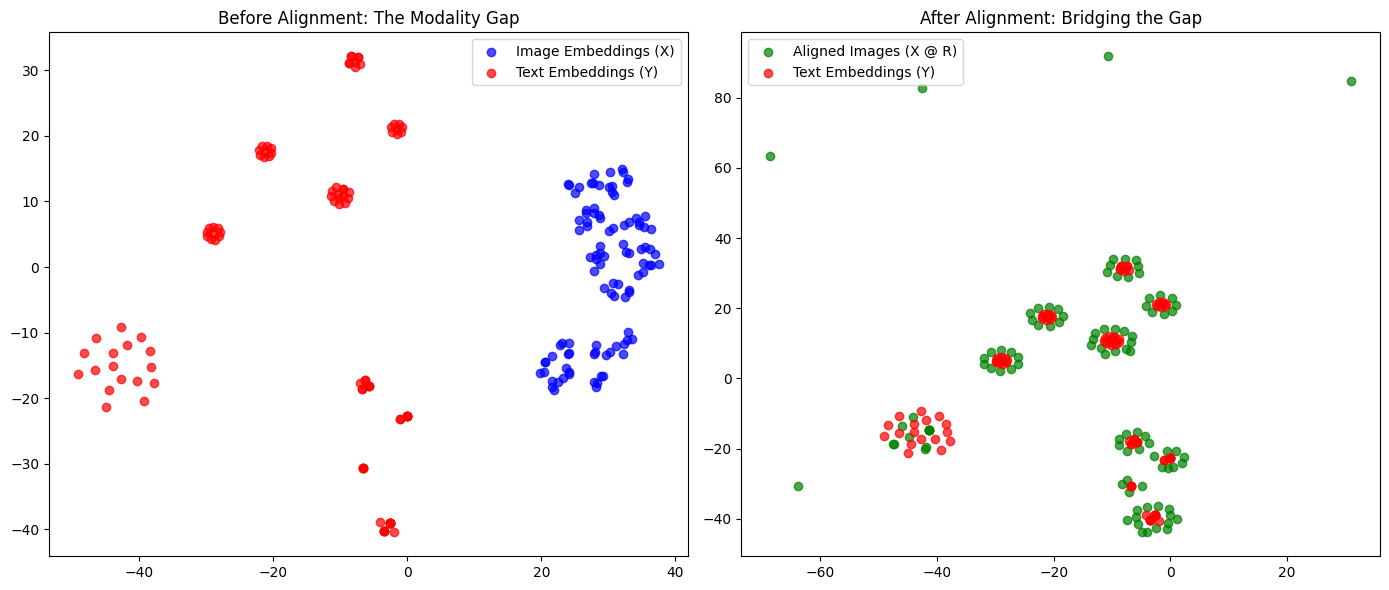

In [4]:
#Task 4.1 Remaining Parts and Analysis


# 3. Dimensionality Reduction with t-SNE
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='pca')

# We combine all three sets to ensure they are projected into the same 2D coordinate system
# X: Original Images, Y: Text, X_aligned: Rotated Images
all_embeddings = np.concatenate([X, Y, X_aligned], axis=0)
reduced_data = tsne.fit_transform(all_embeddings)

# Split the reduced data back into its original groups
x_2d = reduced_data[:100]
y_2d = reduced_data[100:200]
x_aligned_2d = reduced_data[200:]

# 4. Plotting the Results
plt.figure(figsize=(14, 6))

# Subplot 1: Before Alignment (Showing the Modality Gap)
plt.subplot(1, 2, 1)
plt.scatter(x_2d[:, 0], x_2d[:, 1], alpha=0.7, label='Image Embeddings (X)', c='blue')
plt.scatter(y_2d[:, 0], y_2d[:, 1], alpha=0.7, label='Text Embeddings (Y)', c='red')
plt.title("Before Alignment: The Modality Gap")
plt.legend()

# Subplot 2: After Procrustes Alignment
plt.subplot(1, 2, 2)
plt.scatter(x_aligned_2d[:, 0], x_aligned_2d[:, 1], alpha=0.7, label='Aligned Images (X @ R)', c='green')
plt.scatter(y_2d[:, 0], y_2d[:, 1], alpha=0.7, label='Text Embeddings (Y)', c='red')
plt.title("After Alignment: Bridging the Gap")
plt.legend()

plt.tight_layout()
plt.show() # This ensures the plot is displayed in your output

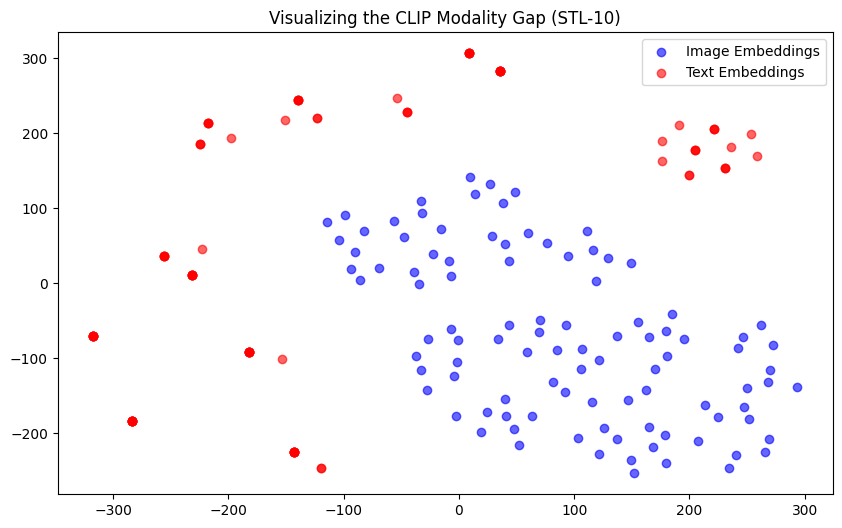

In [5]:
#Task 4.2

import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# (a) Extract 100 Image and Text Embeddings
model.eval()
image_embeddings = []
text_embeddings = []

# We take 100 samples from the test set
with torch.no_grad():
    for i in range(100):
        img, lbl = test_set[i]
        img_input = img.unsqueeze(0).to(device)
        
        # Encode Image
        img_feat = model.encode_image(img_input)
        img_feat /= img_feat.norm(dim=-1, keepdim=True)
        
        # Encode Text (using the 'a photo of a {label}' prompt)
        txt_input = tokenizer([f"a photo of a {class_names[lbl]}"]).to(device)
        txt_feat = model.encode_text(txt_input)
        txt_feat /= txt_feat.norm(dim=-1, keepdim=True)
        
        image_embeddings.append(img_feat.cpu().numpy())
        text_embeddings.append(txt_feat.cpu().numpy())

# Convert lists to numpy arrays
X_img = np.concatenate(image_embeddings)
X_txt = np.concatenate(text_embeddings)

# (b) Dimensionality Reduction using t-SNE
tsne = TSNE(n_components=2, perplexity=15, random_state=42)
all_feats = np.vstack([X_img, X_txt])
reduced_feats = tsne.fit_transform(all_feats)

# Split back into image and text groups
img_2d = reduced_feats[:100]
txt_2d = reduced_feats[100:]

# (c) Visualization
plt.figure(figsize=(10, 6))
plt.scatter(img_2d[:, 0], img_2d[:, 1], c='blue', label='Image Embeddings', alpha=0.6)
plt.scatter(txt_2d[:, 0], txt_2d[:, 1], c='red', label='Text Embeddings', alpha=0.6)
plt.title("Visualizing the CLIP Modality Gap (STL-10)")
plt.legend()
plt.show()

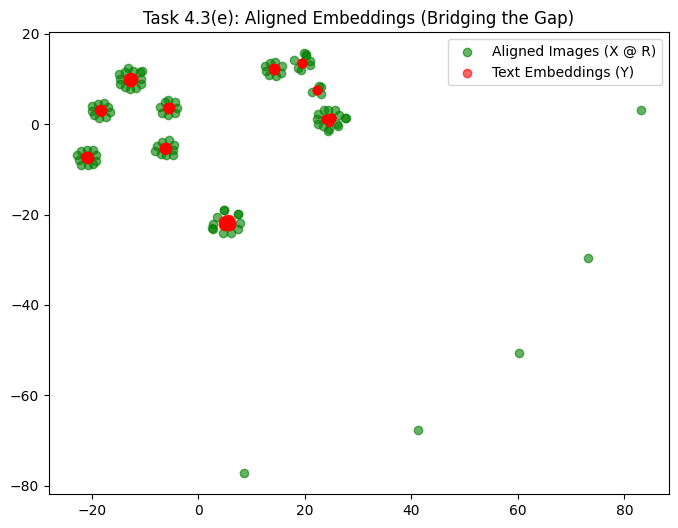

Evaluating Aligned Model: 100%|██████████| 250/250 [00:31<00:00,  7.93it/s]


Final Aligned Accuracy: 96.65%


In [6]:
#Task 4.3

import torch
import numpy as np
from scipy.linalg import orthogonal_procrustes
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm

# (a) & (b) Setup and Pairing
# We use X_img and X_txt (extracted from 100 samples in Task 4.2)
X = X_img  # Image features (100, 512)
Y = X_txt  # Text features (100, 512)

# (c) Learn the optimal rotation matrix R using Orthogonal Procrustes
# This solves the minimization: min ||XR - Y||_F
R, _ = orthogonal_procrustes(X, Y)
R_torch = torch.from_numpy(R).float().to(device)

# (d) Apply the rotation transform to the CLIP embeddings
X_aligned = X @ R

# (e) Visualize the aligned embeddings
tsne_aligned = TSNE(n_components=2, perplexity=15, random_state=42)
# Concatenate Aligned Images and Original Text for projection
combined_data = np.vstack([X_aligned, Y])
reduced_data = tsne_aligned.fit_transform(combined_data)

img_aligned_2d = reduced_data[:100]
txt_2d = reduced_data[100:]

plt.figure(figsize=(8, 6))
plt.scatter(img_aligned_2d[:, 0], img_aligned_2d[:, 1], c='green', label='Aligned Images (X @ R)', alpha=0.6)
plt.scatter(txt_2d[:, 0], txt_2d[:, 1], c='red', label='Text Embeddings (Y)', alpha=0.6)
plt.title("Task 4.3(e): Aligned Embeddings (Bridging the Gap)")
plt.legend()
plt.show()

# (f) Recompute classification accuracy with the aligned embeddings
def evaluate_with_alignment(prompts, rotation_matrix):
    text_tokens = tokenizer(prompts).to(device)
    model.eval()
    correct = 0
    with torch.no_grad():
        # Encode text labels (Proxy for Part 0 comparison)
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        
        for images, labels in tqdm(loader, desc="Evaluating Aligned Model"):
            images, labels = images.to(device), labels.to(device)
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            
            # Apply the learned rotation matrix R to bridge the gap
            image_features_aligned = image_features @ rotation_matrix
            
            # Compute similarity
            logits = (100.0 * image_features_aligned @ text_features.T).softmax(dim=-1)
            predictions = logits.argmax(dim=-1)
            correct += (predictions == labels).sum().item()
            
    return 100 * correct / len(test_set)

# Compare results with the Prompted strategy from 4.1
final_acc = evaluate_with_alignment(strategies["Prompted"], R_torch)
print(f"\nFinal Aligned Accuracy: {final_acc:.2f}%")